In [47]:
from pyforest import *
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')
lazy_imports()

['from sklearn.linear_model import Ridge',
 'from sklearn.ensemble import RandomForestClassifier',
 'from sklearn.linear_model import ElasticNetCV',
 'import tensorflow as tf',
 'import gensim',
 'import xgboost as xgb',
 'import imutils',
 'import statistics',
 'from sklearn.cluster import KMeans',
 'from sklearn.linear_model import LinearRegression',
 'from openpyxl import load_workbook',
 'import plotly.express as px',
 'import fbprophet',
 'from sklearn.model_selection import train_test_split',
 'import awswrangler as wr',
 'from sklearn.ensemble import RandomForestRegressor',
 'import os',
 'from sklearn.feature_extraction.text import CountVectorizer',
 'from sklearn.preprocessing import MinMaxScaler',
 'from pathlib import Path',
 'import pickle',
 'from sklearn.linear_model import Lasso',
 'import glob',
 'from sklearn.linear_model import ElasticNet',
 'from sklearn.linear_model import LogisticRegression',
 'from sklearn.linear_model import RidgeCV',
 'import plotly.graph_objs a

In [48]:
# read dataset
df_covid = pd.read_csv('dataset/imputed-data.csv',header = 0)
df_covid.head()

<IPython.core.display.Javascript object>

,date,county_fips,county_name,state_fips,state_name,covid_19_confirmed_cases,covid_19_deaths,social_distancing_total_grade,social_distancing_visitation_grade,social_distancing_encounters_grade,...,age_55_59,age_60_64,age_65_69,age_70_74,age_75_79,age_80_84,age_85_or_higher,immigrant_student_ratio,death_ratio,population_ratio_in_state
0,2020/01/22,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
1,2020/01/23,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
2,2020/01/24,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
3,2020/01/25,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047
4,2020/01/26,1003,Baldwin County,1,Alabama,0.0,0.0,F,F,F,...,7,7,6,4,3,2,2,0.021048,0.010811,4.46047


In [49]:
# df_informations
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992266 entries, 0 to 992265
Data columns (total 64 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   date                                           992266 non-null  object 
 1   county_fips                                    992266 non-null  int64  
 2   county_name                                    992266 non-null  object 
 3   state_fips                                     992266 non-null  int64  
 4   state_name                                     992266 non-null  object 
 5   covid_19_confirmed_cases                       992266 non-null  float64
 6   covid_19_deaths                                992266 non-null  float64
 7   social_distancing_total_grade                  992266 non-null  object 
 8   social_distancing_visitation_grade             992266 non-null  object 
 9   social_distancing_encounters_grade   

In [50]:
# date as date format
df_covid['date'] = pd.to_datetime(df_covid['date'])
df_covid['date'].head()

<IPython.core.display.Javascript object>

0   2020-01-22
1   2020-01-23
2   2020-01-24
3   2020-01-25
4   2020-01-26
Name: date, dtype: datetime64[ns]

In [51]:
# plt.figure(figsize = (12,6))
# sns.lineplot(x = 'date', y = 'covid_19_confirmed_cases', data = df_covid)
# sns.lineplot(x = 'date', y = 'temperature', data = df_covid)

In [52]:
# top high POPULATED counties
high_case = df_covid[df_covid['date'] == '2020-02-01'].groupby(['county_name'])[
    'total_population'].sum().sort_values(ascending = False)
high_case_10 = list(high_case.index[:10])
high_case_10

['Los Angeles County',
 'Orange County',
 'Cook County',
 'Harris County',
 'Maricopa County',
 'Montgomery County',
 'San Diego County',
 'Jefferson County',
 'Clark County',
 'Dallas County']

In [53]:
# top low POPULATED counties
low_case = df_covid[df_covid['date'] == '2020-02-01'].groupby(['county_name'])[
    'total_population'].sum().sort_values(ascending = True)
low_case_10 = list(low_case.index[:10])
low_case_10

['Crane County',
 'Emporia city',
 'Covington city',
 'Lander County',
 'Haskell County',
 'Fall River County',
 'Huerfano County',
 'Bailey County',
 'Refugio County',
 'Brooks County']

In [54]:
# feature engineering
df_covid['median_household_income_bins'] = pd.qcut(df_covid['median_household_income'],q = 5).cat.codes
df_covid['smoker_bins'] = pd.qcut(df_covid['percent_of_smokers'],q = 13).cat.codes
df_covid['diabetes_bins'] = pd.qcut(df_covid['percent_of_diabetes'],q = 7).cat.codes
df_covid['no_of_death'] = df_covid['death_ratio']*df_covid['total_population']
df_covid['no_of_student_immigrants'] = df_covid['immigrant_student_ratio']*df_covid['total_population']
df_covid['social_distancing_total_grade'] = LabelEncoder().fit_transform(df_covid['social_distancing_total_grade'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
# top states filter
top_counties = df_covid[df_covid['county_name'].isin(high_case_10)]
top_counties = top_states.groupby(['county_name','date'])[['total_population','number_of_meat_plants',
                                    'no_of_death','covid_19_confirmed_cases', 'daily_state_test','virus_pressure',
                                       'no_of_student_immigrants','airport_distance']].mean().reset_index()
top_counties.head()

,county_name,date,total_population,number_of_meat_plants,no_of_death,covid_19_confirmed_cases,daily_state_test,virus_pressure,no_of_student_immigrants,airport_distance
0,Clark County,2020-01-22,580971.8,7.4,4596.709451,0.0,0.0,0.0,7018.4,56.680365
1,Clark County,2020-01-23,580971.8,7.4,4596.709451,0.0,0.0,0.0,7018.4,56.680365
2,Clark County,2020-01-24,580971.8,7.4,4596.709451,0.0,0.0,0.0,7018.4,56.680365
3,Clark County,2020-01-25,580971.8,7.4,4596.709451,0.0,0.0,0.0,7018.4,56.680365
4,Clark County,2020-01-26,580971.8,7.4,4596.709451,0.0,0.0,0.0,7018.4,56.680365


In [56]:
# create individual df for counties
county_df = {}
county_df = {}
for county in high_case_10:
    county_df[county] = pd.DataFrame(data = top_counties[top_counties['county_name'] == county])
    county_df[county] = county_df[county][['date','total_population','number_of_meat_plants',
                                    'no_of_death','covid_19_confirmed_cases','virus_pressure',
                                       'no_of_student_immigrants','airport_distance']].resample('D', on='date').mean()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
# testing dfs
county_df['Los Angeles County'].head()

,total_population,number_of_meat_plants,no_of_death,covid_19_confirmed_cases,virus_pressure,no_of_student_immigrants,airport_distance
date,,,,,,,
2020-01-22,10105518.0,288.0,64271.09448,0.0,0.00,227147.0,0.0
2020-01-23,10105518.0,288.0,64271.09448,0.0,0.00,227147.0,0.0
2020-01-24,10105518.0,288.0,64271.09448,0.0,0.00,227147.0,0.0
2020-01-25,10105518.0,288.0,64271.09448,0.0,0.00,227147.0,0.0
2020-01-26,10105518.0,288.0,64271.09448,1.0,0.25,227147.0,0.0


<AxesSubplot:xlabel='date'>

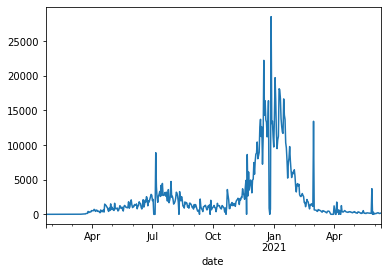

In [58]:
county_df['Los Angeles County']['covid_19_confirmed_cases'].plot()

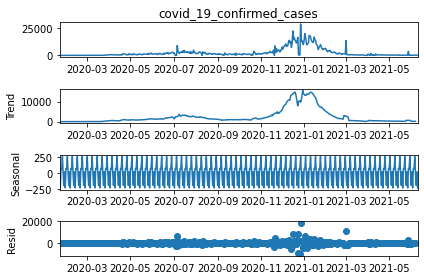

In [59]:
# check seasonal decompose
result = seasonal_decompose(county_df['Los Angeles County']['covid_19_confirmed_cases'],model = 'add')
result.plot();

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date'>

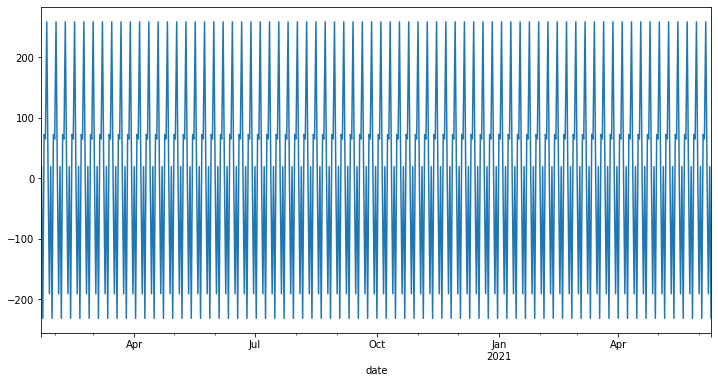

In [60]:
plt.figure(figsize = (12,6))
result.seasonal.plot()

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date'>

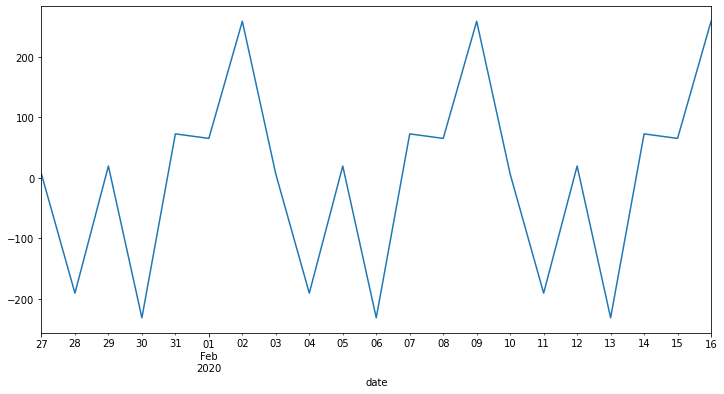

In [61]:
plt.figure(figsize = (12,6))
result.seasonal[5:26].plot()

In [62]:
# train test split
from sklearn.model_selection import train_test_split

train_df = {}
test_df = {}
future_df = {}

for county in high_case_10:
#     X_train,X_test,y_train,y_test = train_test_split(state_df[state].loc[:,
#                                                     ~state_df[state].columns.isin(['covid_19_confirmed_cases','date'])],
#                                             state_df[state]['covid_19_confirmed_cases'],test_size = 0.4,shuffle = False,
#                                                      stratify = None)

    train = county_df[county][county_df[county].index <= '2020-12-31']
    test = county_df[county][(county_df[county].index > '2020-12-31')]

    train_df[county] = train
    test_df[county] = test

<AxesSubplot:xlabel='date'>

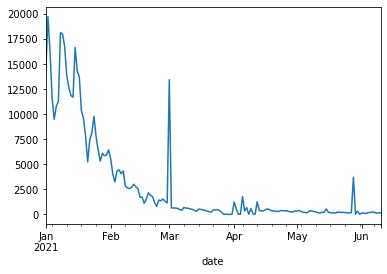

In [63]:
test_df['Los Angeles County']['covid_19_confirmed_cases'].plot()

In [64]:
# checking for each states forecast range
for county in high_case_10:
    print(county , " : whole : ", len(county_df[county].index))
    print(county , " : train : ", len(train_df[county].index))
    print(county , " : test : ", len(test_df[county].index))

Los Angeles County  : whole :  506
Los Angeles County  : train :  345
Los Angeles County  : test :  161
Orange County  : whole :  506
Orange County  : train :  345
Orange County  : test :  161
Cook County  : whole :  506
Cook County  : train :  345
Cook County  : test :  161
Harris County  : whole :  506
Harris County  : train :  345
Harris County  : test :  161
Maricopa County  : whole :  506
Maricopa County  : train :  345
Maricopa County  : test :  161
Montgomery County  : whole :  506
Montgomery County  : train :  345
Montgomery County  : test :  161
San Diego County  : whole :  506
San Diego County  : train :  345
San Diego County  : test :  161
Jefferson County  : whole :  506
Jefferson County  : train :  345
Jefferson County  : test :  161
Clark County  : whole :  506
Clark County  : train :  345
Clark County  : test :  161
Dallas County  : whole :  506
Dallas County  : train :  345
Dallas County  : test :  161


In [65]:
train_df['Los Angeles County'].columns

Index(['total_population', 'number_of_meat_plants', 'no_of_death',
       'covid_19_confirmed_cases', 'virus_pressure',
       'no_of_student_immigrants', 'airport_distance'],
      dtype='object')

#### what is Auto Regression ?
Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. It is a very simple idea that can result in accurate forecasts on a range of time series problems
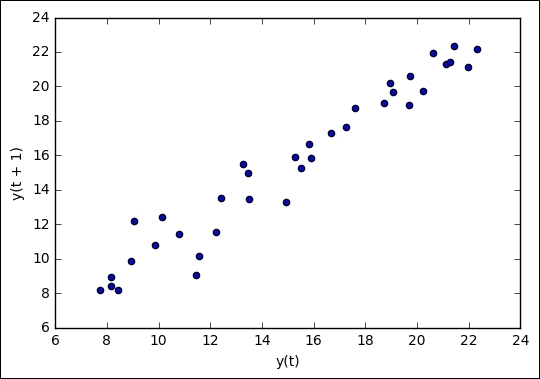

#### what is Differentiation ?
Differencing is a method of transforming a time series dataset. It can be used to remove the series dependence on time, so-called temporal dependence. This includes structures like trends and seasonality.
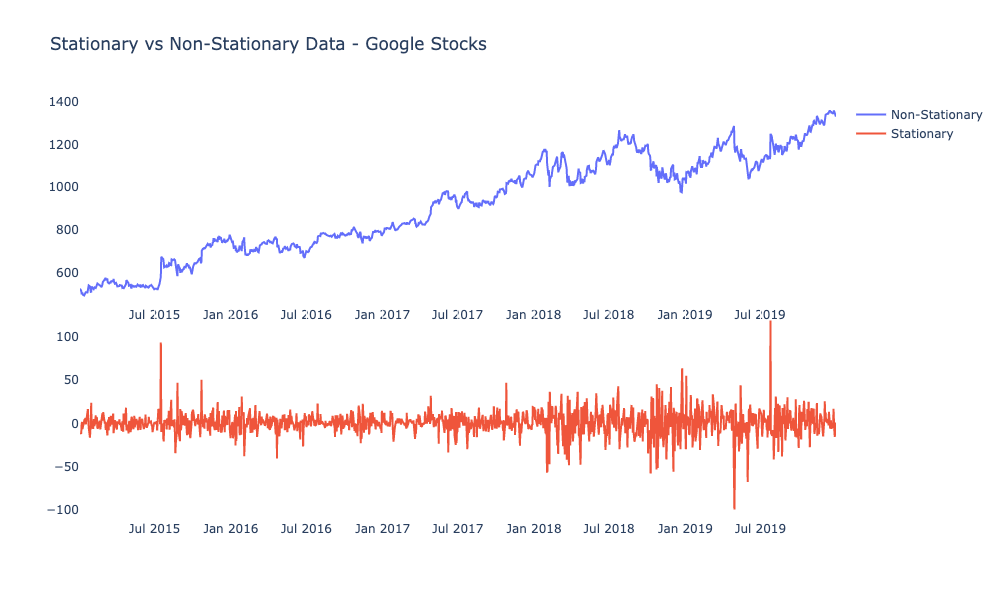

#### what is Moving Average ?
A moving average is defined as an average of fixed number of items in the time series which move through the series by dropping the top items of the previous averaged group and adding the next in each successive average.
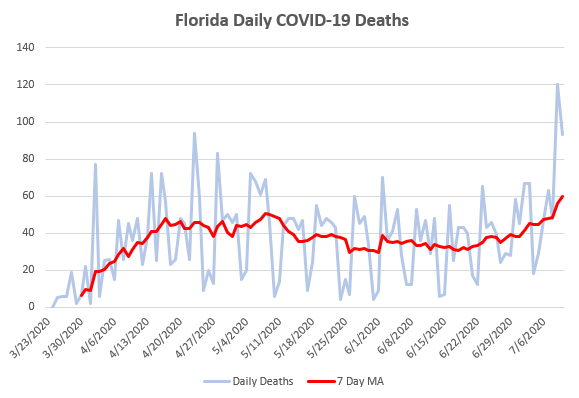

In [66]:
# auto_arima fit #c
from pmdarima import auto_arima
grid_model = {}
for county in high_case_10:
    grid_model[county] = auto_arima(county_df[county]['covid_19_confirmed_cases'],
                        exogenous = county_df[county][['total_population', 'number_of_meat_plants', 'no_of_death',
       'virus_pressure', 'no_of_student_immigrants',
       'airport_distance']],seasonal = True,m = 7,trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=11697.749, Time=0.17 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[7]          
Total fit time: 0.200 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Tim

In [67]:
for county in high_case_10:
    print(grid_model[county].summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  506
Model:                        SARIMAX   Log Likelihood               -5841.875
Date:                Mon, 04 Apr 2022   AIC                          11697.749
Time:                        13:14:06   BIC                          11727.335
Sample:                    01-22-2020   HQIC                         11709.353
                         - 06-10-2021                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
total_population          2.908e-05      0.009      0.003      0.997      -0.018       0.018
number_of_meat_plants     8.288e-10   2.63e-07      0.003      0.997   -5.16e-07    5.17e

In [68]:
# sarimax model 
ts_model = {}
for county in high_case_10:
    ts_model[county] = SARIMAX(train_df[county]['covid_19_confirmed_cases'],
                        exog = train_df[county].loc[:,
                                             ~train_df[county].columns.isin(['covid_19_confirmed_cases'])],
                   order = (0,0,0), seasonal_order = (0,0,0,7)).fit()
    print(ts_model[county].summary())

                                  SARIMAX Results                                   
Dep. Variable:     covid_19_confirmed_cases   No. Observations:                  345
Model:                              SARIMAX   Log Likelihood               -3946.834
Date:                      Mon, 04 Apr 2022   AIC                           7907.668
Time:                              13:14:06   BIC                           7934.573
Sample:                          01-22-2020   HQIC                          7918.383
                               - 12-31-2020                                         
Covariance Type:                        opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
total_population          4.071e-05      0.009      0.005      0.996      -0.018       0.018
number_of_meat_plants      1.16e-09   2.5

                                  SARIMAX Results                                   
Dep. Variable:     covid_19_confirmed_cases   No. Observations:                  345
Model:                              SARIMAX   Log Likelihood               -3493.345
Date:                      Mon, 04 Apr 2022   AIC                           7000.689
Time:                              13:14:07   BIC                           7027.594
Sample:                          01-22-2020   HQIC                          7011.404
                               - 12-31-2020                                         
Covariance Type:                        opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
total_population          2.413e-05      0.004      0.007      0.995      -0.007       0.007
number_of_meat_plants     1.149e-10   1.7

                                  SARIMAX Results                                   
Dep. Variable:     covid_19_confirmed_cases   No. Observations:                  345
Model:                              SARIMAX   Log Likelihood               -2960.306
Date:                      Mon, 04 Apr 2022   AIC                           5934.611
Time:                              13:14:08   BIC                           5961.516
Sample:                          01-22-2020   HQIC                          5945.326
                               - 12-31-2020                                         
Covariance Type:                        opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
total_population           5.84e-06      0.004      0.002      0.999      -0.007       0.007
number_of_meat_plants     1.133e-10   7.0

In [69]:
# forecast first
forecast = {}
for county in high_case_10:
    forecast_temp = ts_model[county].forecast(steps = 161,exog = test_df[county].iloc[:161,
                                             ~test_df[county].columns.isin(['covid_19_confirmed_cases'])],
            typ = 'levels').rename('forecast_sarimax')
    forecast[county] = pd.DataFrame(forecast_temp)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
forecast['Los Angeles County'][:7]

,forecast_sarimax
2021-01-01,17551.033509
2021-01-02,13936.204792
2021-01-03,11732.137686
2021-01-04,5051.183222
2021-01-05,9665.576865
2021-01-06,8802.196049
2021-01-07,11238.966101


In [71]:
test_df['Los Angeles County']['covid_19_confirmed_cases'][:7]

date
2021-01-01    14217.0
2021-01-02    19734.0
2021-01-03    16314.0
2021-01-04    11640.0
2021-01-05     9490.0
2021-01-06    10761.0
2021-01-07    11269.0
Freq: D, Name: covid_19_confirmed_cases, dtype: float64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date', ylabel='covid_19_confirmed_cases'>

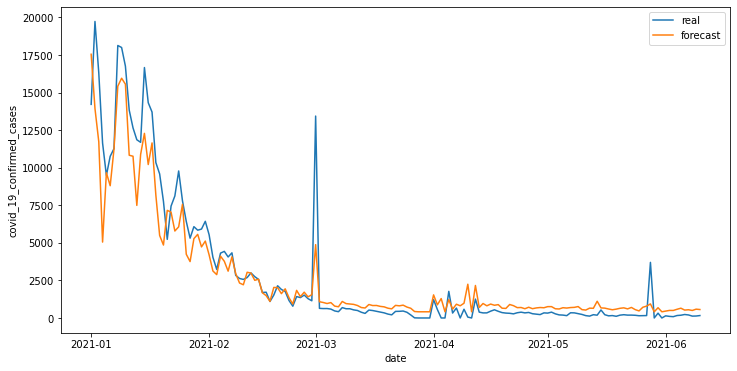

In [72]:
#forecast plot
plt.figure(figsize = (12,6))
sns.lineplot(x = test_df['Los Angeles County'].iloc[:161].index,
             y = test_df['Los Angeles County'].iloc[:161]['covid_19_confirmed_cases'],label = 'real'
             ,legend = True)
sns.lineplot(x = forecast['Los Angeles County'].index, y = forecast['Los Angeles County']['forecast_sarimax'],label = 'forecast')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date', ylabel='covid_19_confirmed_cases'>

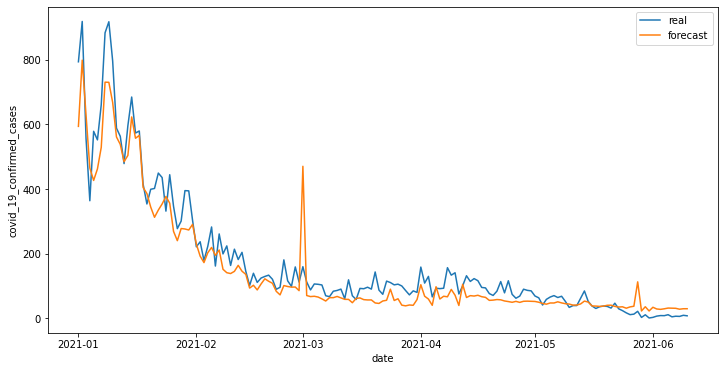

In [73]:
#forecast plot
plt.figure(figsize = (12,6))
sns.lineplot(x = test_df['Orange County'].iloc[:161].index,
             y = test_df['Orange County'].iloc[:161]['covid_19_confirmed_cases'],label = 'real'
             ,legend = True)
sns.lineplot(x = forecast['Orange County'].index, y = forecast['Orange County']['forecast_sarimax'],label = 'forecast')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='date', ylabel='covid_19_confirmed_cases'>

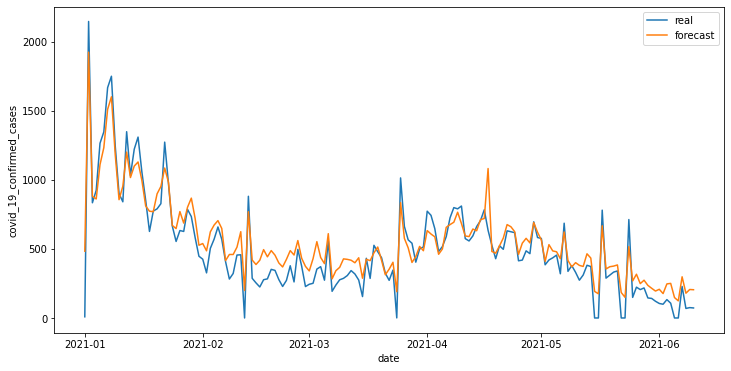

In [74]:
#forecast plot
plt.figure(figsize = (12,6))
sns.lineplot(x = test_df['Cook County'].iloc[:161].index,
             y = test_df['Cook County'].iloc[:161]['covid_19_confirmed_cases'],label = 'real'
             ,legend = True)
sns.lineplot(x = forecast['Cook County'].index, y = forecast['Cook County']['forecast_sarimax'],label = 'forecast')

In [82]:
# evaluating
np.sqrt(metrics.mean_squared_error(test_df['Orange County'].iloc[:7]['covid_19_confirmed_cases']
                                   ,forecast['Orange County'].iloc[:7]['forecast_sarimax']))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

129.97111894795754

In [83]:
test_df['Orange County'].iloc[:7]['covid_19_confirmed_cases'].mean() # 20 % error

631.9795918367346

In [80]:
np.sqrt(metrics.mean_squared_error(test_df['Los Angeles County'].iloc[:7]['covid_19_confirmed_cases']
                                   ,forecast['Los Angeles County'].iloc[:7]['forecast_sarimax'])) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4017.9031434940985

In [81]:
test_df['Los Angeles County'].iloc[:7]['covid_19_confirmed_cases'].mean() # 30% error

13346.42857142857

In [84]:
np.sqrt(metrics.mean_squared_error(test_df['Cook County'].iloc[:7]['covid_19_confirmed_cases']
                                   ,forecast['Cook County'].iloc[:7]['forecast_sarimax']))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

221.27769361057588

In [85]:
test_df['Cook County'].iloc[:7]['covid_19_confirmed_cases'].mean() # 18% error

1170.357142857143

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

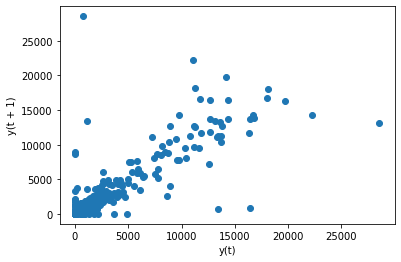

In [89]:
# lag plot Los Angeles County
pd.plotting.lag_plot(county_df['Los Angeles County']['covid_19_confirmed_cases'], lag=1)